# Goal: To conduct an exporatory data analysis and come up with answers of important business related questions

In [ ]:
# libraries
!pip install pandas-profiling panel mplcursors

# Data Import

In [1]:
import pandas as pd
mc = pd.read_csv('google-analytics-public-analyst-case-study_-_marketing_channel_timeseries.csv')

# EDA

## Data Profiling

In [2]:
from pandas_profiling import ProfileReport
mc_profile = ProfileReport(mc)
mc_profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Key Observations

From the above Profiling we observe few key things about the given data:
* `transactions` and `totalTransactionRevenue` is correlated and highly positive.
* `visits`, `bounces` and `transactions` are siginificantly correlated
* `source` and `referralPath` has large number of distinct values (high cardinality).
* `referralPath` feature has 40% of missing values.
* From the histogram we observe, `transactions` as a label, which ranged from 0 to 71, is highly skewed with large number of obervations having 0 of value (meaning no transactions). This makes an imbalanced dataset for machine learning classification model.

## Which marketing source delivers the most bookings?

The best way to find the outcome of marketing source that resulted in booking is to plot the bar chart and compare it visually. Here is the interactive chart from `marketing_channel_timeseries` dataset to understand the behaviour of different features with one another on the entire dataset.

In [3]:
import panel as pn
from matplotlib.figure import Figure
import mplcursors
%matplotlib widget
%matplotlib inline

In [4]:
def get_plot(data, x_col='source', y_col='transactions'):
    x = data.groupby(x_col, as_index=False)[y_col].sum().sort_values(by=y_col, ascending=False).head(15)
    fig = Figure(figsize=(10,5))
    ax = fig.add_subplot()
    ax.barh(x[x_col],x[y_col])
    ax.set_xlabel(y_col)
    ax.set_ylabel(x_col)
    ax.set_title(x_col+' vs '+ y_col)
    
    # hover-feature
    cursor = mplcursors.cursor(hover=True)
    @cursor.connect("add")
    def on_add(sel):
        sel.annotation.set(text=x[sel.target.index])
        
    fig.canvas.toolbar_visible = True
    fig.canvas.header_visible = False
    fig.canvas.resizable = True
    return fig

pn.extension(sizing_mode="stretch_width", template="fast")
pn.pane.Markdown("""
<h2> Panel App to visualise features interactively.</h2>
"""
).servable()

Markdown(str, sizing_mode='stretch_width')

In [5]:
variable = pn.widgets.Select(
    name="Variable", value="source", options=list(mc.columns)
)
variable.servable(area="sidebar")

Select(name='Variable', options=['date_week', ...], sizing_mode='stretch_width', value='source')

In [6]:
independent = pn.widgets.Select(
    name="Output", value="transactions", options=['bounces','visits', 'transactions', 'totalTransactionRevenue']
)
independent.servable(area="sidebar")

Select(name='Output', options=['bounces', 'visits', ...], sizing_mode='stretch_width', value='transactions')

ParamFunction(function, sizing_mode='scale_both')
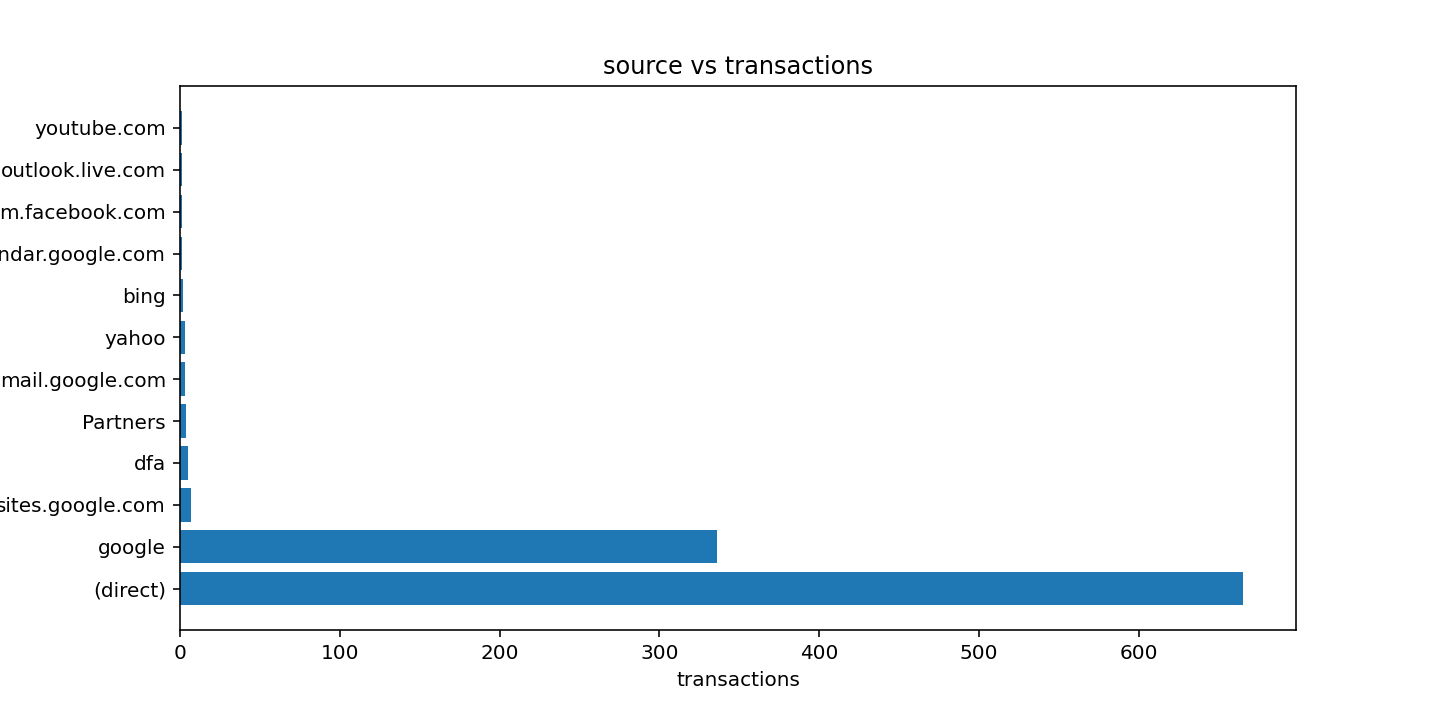

In [7]:
# Reactive Functions
mc = mc[mc['transactions']>0]
reactive = pn.bind(get_plot, mc, variable, independent)
pn.panel(reactive, sizing_mode="scale_both").servable()

### Observations:

From the above bar chart, we can observe that customers completed their bookings through `direct` and `google` as a source. Hence, it is advisable to spend more on these two 'sources' for advertisements to increase revenue. 

## How does bounce rate vary by marketing channel (source & medium)? Are the differences significant?

In [8]:
variable = pn.widgets.Select(
    name="Variable", value="medium", options=list(mc.columns)
)
variable.servable(area="sidebar")

Select(name='Variable', options=['date_week', ...], sizing_mode='stretch_width', value='medium')

In [9]:
independent = pn.widgets.Select(
    name="Output", value="transactions", options=['visits', 'transactions', 'totalTransactionRevenue']
)
independent.servable(area="sidebar")

Select(name='Output', options=['visits', 'transactions',...], sizing_mode='stretch_width', value='transactions')

ParamFunction(function, sizing_mode='scale_both')
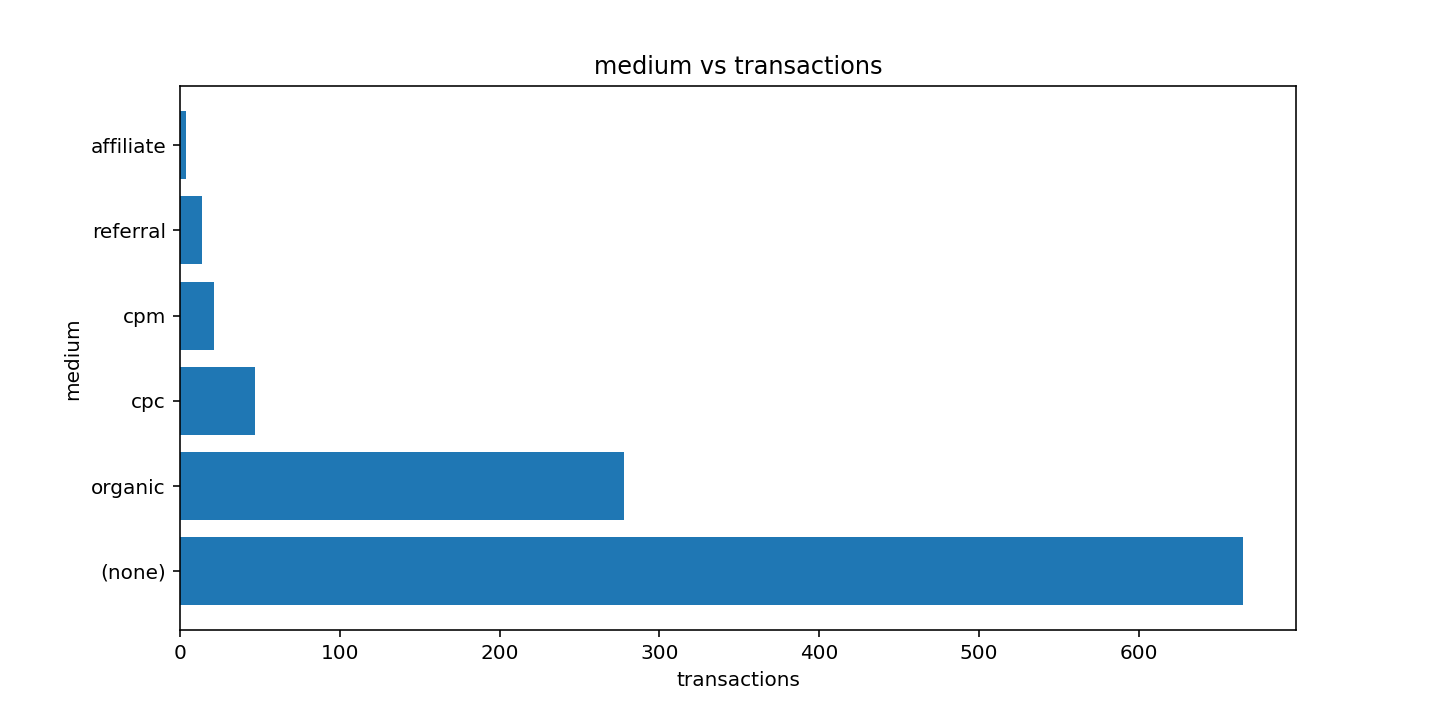

In [10]:
# Reactive Functions
reactive = pn.bind(get_plot, mc, variable, independent)
pn.panel(reactive, sizing_mode="scale_both").servable()

### Explaination:

From the Correlation-coefficients from 'mc_profile' profiling, we observe that the source-bounces Phik coefficient (φk) is around 0.0 and that of medium-bounce is 0.2. The difference is not significant. It can also be observed from the chart, transactions(successful bookings) has similar bar-plot structure.

## Which factors most strongly influence conversion rate (transactions / visit) ?

In the initial exploration of data analysis, we noted that `transactions` has a wide range and highly skewed. In order to find the factors that most strongly influence conversion rate (transactions), the data is discretised into 4 bins and a new column `tier` is added as below:

* Transaction=0 :: tier=0
* Transaction=1 :: tier=1
* Transaction>1 and Transaction<5 :: tier=2
* Transaction=>5 and Transaction<10 :: tier=3
* Transaction=>10 :: tier=4

In [15]:
# Python code for discretization
import numpy as np
conditions = [
    (mc['transactions'] == 0),
    (mc['transactions'] == 1),
    ((mc['transactions'] > 1) & (mc['transactions'] < 5)),
    ((mc['transactions'] > 5) & (mc['transactions'] < 10)),
    (mc['transactions'] >= 10)
    ]

# create a list of the values we want to assign for each condition
values = ['0', '1', '2', '3', '4']

# create a new column and use np.select to assign values to it using our lists as arguments
mc['tier'] = np.select(conditions, values)
mc[mc.select_dtypes(['object']).columns] = mc.select_dtypes(['object']).apply(lambda x: x.astype('category'))

In [16]:
from IPython.display import Image

In [17]:
Image(url= "Factors influencing conversion rate - pipeline.png", width=1600, height=800)

In [18]:
Image(url= "Factors influencing conversion rate.png", width=1600, height=800)

### Explaination:

The first image above shows the pipeline created in 'RapidMiner' software. After the data is retrieved, the `transactions` column is set as labels and descretized according to above conditions. Finally, weights are fetched by information gain value. The higher the value, more important is the feature variable for target. From the plot, it is clear that `totalTransactionRevenue` contributes maximum to the groups. The `referralPath`, `visits` and `source` supports almost equally to the newly created classes.

## What appears to be the biggest opportunity to drive incremental bookings?

In order to increase revenue, it is important to find out which factors likely to contribute for subsequent bookings (transactions). For this we created three classes (range) and factors that maximises each class is identified. The ranges are created by discretizing according to the condition given below:

* range:: transaction=1 
* range2:: transaction=2-5
* range3: transaction=6-Infinity


The following pipeline is created: 

Filter only successful transactions > Simulate on different algorithms to maximize the `range3` > Identify important features. 

The outcome of each algorithm is shown below. 

### [1] Gradient Booster 

In [19]:
Image(url= "transaction prediction models - Gradient Booster.jpg", width=1600, height=800)

In [20]:
Image(url= "transaction prediction models - Gradient Booster (features).jpg", width=1600, height=800)

### [2] Logistic Regression

In [21]:
Image(url= "transaction prediction models - Logistic regression.jpg", width=1600, height=800)

In [22]:
Image(url= "transaction prediction models - Logistic regression (features).jpg", width=1600, height=800)

### [3] Random Forest

In [23]:
Image(url= "transaction prediction models - Random Forest.jpg", width=1600, height=800)

In [24]:
Image(url= "transaction prediction models - Random Forest (features).jpg", width=1600, height=800)

The overall weights by correlations amongst all the tiers are also obtained. The extracted feature along with its weight is shown below.

In [25]:
Image(url= "Weights by Correlations.jpg", width=1600, height=800)

# Conclusion

In the case study, the goal was to analyse the customer booking's data. After the taget label i.e transactions, it was observed that company has missed out large number of successful transactions. It was observed 'direct' and 'google' are the major sources from which company was able to convert large number transactions. Although `medium` and `source` has similar motif towards conversion rate, it is to be noted that medium has many unknown (none) values. `referralPath` has 40% of missing values hence no firm conclusion can be drawn. Therefore, data collection process need to be upgraded for better analysis. The large number of successful transaction was found to be positively associated with `region`. Hence, it is advisable to spend more on region specific advertisments to increase conversion rate. Since the conversion rate (visits/transactions) is directly related to revenue, focusing on the identified features will help improve the revenue of the company. However, it should be noted that this is not exhaustive analysis.